In [21]:
import os
import tensorflow as tf
import glob
import shutil
import matplotlib.image
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import zipfile
import imagesize
from collections import Counter
import numpy as np

### Load data

In [4]:
with zipfile.ZipFile("combined_dataset.zip","r") as zip_ref:
    zip_ref.extractall("data")

### Explore data

In [9]:
directory="/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset"
train_directory="/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training"
test_directory="/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing"

file_count = sum(len(files) for _, _, files in os.walk(directory))
print(file_count)

10290


In [6]:
#get number of training images
file_count_train = sum(len(files) for _, _, files in os.walk(train_directory))
print(file_count_train)

8583


In [10]:
#get number of test images
file_count_test = sum(len(files) for _, _, files in os.walk(test_directory))
print(file_count_test)

1706


In [11]:
#get all filenames
filenames = list(Path(".").rglob("*.[jJ][pP][gG]"))

In [14]:
image_shapes=[]
widths=[]
heights=[]
for i in filenames:
    #get width and height of image
    width, height = imagesize.get(i)
    image_shapes.append((width,height))
    widths.append(width)
    heights.append(height)

In [17]:
#get count of image shapes
Counter(image_shapes)

Counter({(167, 167): 3264,
         (236, 280): 6,
         (227, 213): 6,
         (321, 351): 6,
         (200, 248): 7,
         (236, 260): 25,
         (236, 236): 239,
         (228, 228): 6,
         (236, 228): 7,
         (200, 243): 7,
         (235, 261): 7,
         (205, 249): 7,
         (236, 268): 6,
         (236, 290): 13,
         (235, 228): 7,
         (233, 226): 6,
         (225, 259): 6,
         (236, 295): 14,
         (236, 243): 16,
         (211, 236): 6,
         (235, 227): 24,
         (208, 225): 7,
         (278, 253): 6,
         (218, 234): 7,
         (236, 231): 13,
         (236, 251): 24,
         (210, 234): 6,
         (314, 258): 6,
         (212, 236): 7,
         (234, 224): 13,
         (234, 218): 19,
         (236, 273): 7,
         (234, 234): 6,
         (234, 225): 14,
         (208, 217): 6,
         (236, 270): 6,
         (205, 214): 7,
         (236, 262): 19,
         (224, 262): 6,
         (221, 257): 6,
         (236, 300): 13,

It looks like once again the minimum image resolution is 167x167 pixels, so we can again resize all the images to this size.

In [18]:
#for training data
for dirpath, dirnames, filenames in os.walk(train_directory):
    number_of_class_files = len(filenames)
    print ("Files in ", dirpath, number_of_class_files)

Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training 1
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training/glioma 2147
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training/notumor 1990
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training/pituitary 2284
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training/meningioma 2161


In [19]:
#for testing data
for dirpath, dirnames, filenames in os.walk(test_directory):
    number_of_class_files = len(filenames)
    print ("Files in ", dirpath, number_of_class_files)

Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing 1
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing/pituitary 374
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing/notumor 510
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing/meningioma 421
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing/glioma 400


Let's now make some plots to analyze the class distribution

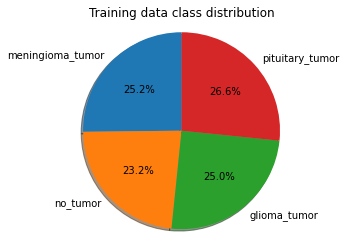

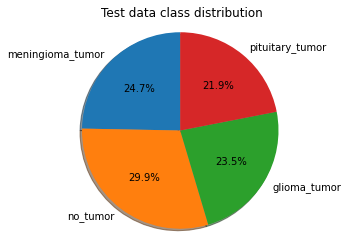

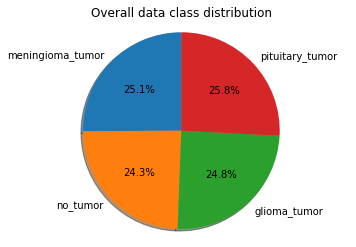

In [22]:
labels = 'meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor'
values_train=[2161,1990,2147,2284]
values_test=[421,510,400,374]
values_overall=np.add(values_train, values_test)

fig1, ax1 = plt.subplots()
ax1.pie(values_train, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
ax1.title.set_text('Training data class distribution')

fig2, ax2 = plt.subplots()
ax2.pie(values_test, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  
ax2.title.set_text('Test data class distribution')


fig3, ax3 = plt.subplots()
ax3.pie(values_overall, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  
ax3.title.set_text('Overall data class distribution')


plt.show()

We can see that classes are way more balanced now compared to the initial dataset (we don't have classes with just 15% of the examples like then). This should the class imbalance problems that existed in our first models.<br>
Next we will again resize our data to prepare it for training.

### Resize images

In [23]:
TRAIN_IMAGE_SAVE_DIR = 'preprocessed_augmented_data/Training'
TEST_IMAGE_SAVE_DIR = 'preprocessed__augmented_data/Testing'
TRAIN_IMAGE_DIR="/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Training"
TEST_IMAGE_DIR="/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data/combined_dataset/Testing"
train_images = os.listdir(train_directory)
test_images = os.listdir(test_directory)

In [24]:
def resize_images(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [167, 167])
    return img

In [25]:
#creates the directory where the file will be stored if it doesn't exist already
def ensure_directory_exists(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [26]:
#get the location of all train and test images
train_images = glob.glob(TRAIN_IMAGE_DIR + '/**/*.jpg', recursive=True)
test_images = glob.glob(TEST_IMAGE_DIR + '/**/*.jpg', recursive=True)

In [28]:
#resize all training images and copy them to another folder
if not os.path.exists(TRAIN_IMAGE_SAVE_DIR):
    os.makedirs(TRAIN_IMAGE_SAVE_DIR)
    
for i in train_images:
    resized_img = resize_images(os.path.join(i))
    new_image_location=i.replace("data/combined_dataset","augmented_dataset_resized")
    ensure_directory_exists(new_image_location)
    tf.keras.utils.save_img(new_image_location, resized_img)

In [31]:
#check that the function worked ok
for dirpath, dirnames, filenames in os.walk("/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized"):
    number_of_class_files = len(filenames)
    print ("Files in ", dirpath, number_of_class_files)

Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized 0
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Training 0
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Training/notumor 1990
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Training/meningioma 2161
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Training/pituitary 2284
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Training/glioma 2147


In [44]:
#shutil.rmtree("/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/data") 


In [32]:
#resize all test images and copy them to another folder
if not os.path.exists(TEST_IMAGE_SAVE_DIR):
    os.makedirs(TEST_IMAGE_SAVE_DIR)
    
for i in test_images:
    resized_img = resize_images(os.path.join(i))
    new_image_location=i.replace("data/combined_dataset","augmented_dataset_resized")
    ensure_directory_exists(new_image_location)
    tf.keras.utils.save_img(new_image_location, resized_img)

In [34]:
#check that the function worked ok
for dirpath, dirnames, filenames in os.walk("/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Testing"):
    number_of_class_files = len(filenames)
    print ("Files in ", dirpath, number_of_class_files)

Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Testing 0
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Testing/meningioma 421
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Testing/notumor 510
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Testing/glioma 400
Files in  /home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized/Testing/pituitary 374


### Check if images were resized

In [35]:
#get the name of all the resized images
filenames = list(Path("/home/dlmain/mcata/APPLIED DEEP LEARNING PROJECT/augmented_dataset_resized").rglob("*.[jJ][pP][gG]"))

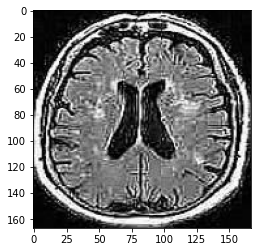

In [36]:
img = mpimg.imread(filenames[223])
imgplot = plt.imshow(img)
plt.show()

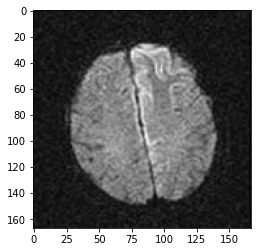

In [37]:
img = mpimg.imread(filenames[699])
imgplot = plt.imshow(img)
plt.show()

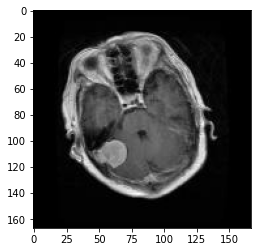

In [38]:
img = mpimg.imread(filenames[2304])
imgplot = plt.imshow(img)
plt.show()

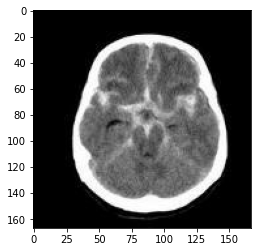

In [39]:
img = mpimg.imread(filenames[1188])
imgplot = plt.imshow(img)
plt.show()

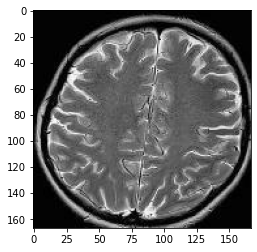

In [40]:
img = mpimg.imread(filenames[91])
imgplot = plt.imshow(img)
plt.show()

We can see that the images were resized and are now ready for training, which we will do in the next script.